<a href="https://colab.research.google.com/github/donbcolab/AIE3/blob/main/fine_tuning_llama_3_8b_instruct_for_summarization_assignment_version_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ⚠ IMPORTANT ⚠

You will need at least 15GB of VRAM (GPU RAM) to run this notebook.

If you're running this locally - please ensure you have the correct hardware to support the fine-tuning.

# Task Fine-tuning a GPT-style model using `peft`, `transformers` and `bitsandbytes`

In the following notebook, we'll task fine-tune a GPT-style model on the summarization task using:

- [QLoRA](https://arxiv.org/pdf/2305.14314.pdf)/[LoRA](https://arxiv.org/pdf/2106.09685.pdf)

The basic idea is that we will fine-tune an "adapter" which will represent a small subset of trainable weights on our task. This will allow us to instruct-tune a comparitively large model with consumer level resources.

The model we'll be instruct-tuning today is [`NousResearch/Meta-Llama-3-8B-Instruct`](https://huggingface.co/NousResearch/Meta-Llama-3-8B-Instruct)!

> NOTE: The official Llama 3 weights are gated behind a EULA - while using the NousResearch version does not change the acceptable use of the model, it does shortcut needing to wait for the EULA to be accepted.

### Homework Sections

The notebook will be broken into the following sections:

1. Breakout Room #1:
  - Task #1: Loading the Model
2. Breakout Room #2:
  - Task #2: Data and Data Prep.
  - Task #3: Setting up PEFT LoRA
  - Task #4: Training the Model
  - Task #5: Share Your Model!

There are a total of 6 Questions, and 1 Activity, all of which must be completed to receive full marks for the homework.


Absolutely, let's add some Unicode coolness to your post to make it more engaging!

---

## 🌟 Lessons Learned
- 🚀 **Only going part way down a rabbit hole, and pivoting earlier:**
  - 🔄 Finding [alternate ways to merge the adapter](https://github.com/donbcolab/AIE3/blob/main/save_pretrained_merged_adapters.ipynb) after the fine-tuning process is complete.
- 🤖 **Using an LLM to search for information on special tokens** (this is *hard*).
- 🖼️ **Finding multiple ways to visualize the model architecture and fine-tuning process** (see accordion below).

### 🏗️ Model Architecture App
- My [Model Explorer App](https://huggingface.co/spaces/dwb2023/model_explorer4) helped highlight issues with the process (failed merge, issues with versioning, etc.).
   - Click on appropriate examples to retrieve model architecture:
     - **Base:**
       - NousResearch/Meta-Llama-3-8B-Instruct
     - **LoRA:**
       - dwb2023/llama38binstruct_summarize

- 🧩 **Mermaid Model for end-to-end flow:** Captures potential enhancements to the Model Explorer App.

## 🌱 Lessons Not Fully Learned
- 🤷‍♂️ **Use of AutoTokenizer in Fine Tuning VS model specific special tokens:**
  - Refer to this [course question](https://discord.com/channels/1135695983720792216/1250871138989641748/1250871138989641748).
- 📚 **Use of multiple datasets to create various adapter layers.**
- 🔧 **Refining techniques related to HF tools, including versioning and pushing to the hub:**
  - HF Models
    - without effective versioning you end up with "Franken-Models"
    - cool learning oppty, and chance to create a v3 of the merged model (currently holding off as I need to manage my GPU budget closely due to build - ship -share and final project work)
  - HF Datasets
    - what a powerful tool
- continue to efine my understand of the "WHY" and "WHAT" behind qLORA and PEFT.  (see notes at the VERY end... I'm not that mean)

## Mermaid Model: Fine Tuning flow
- consider this only a draft used to help teach an LLM
- potential enhancements for Gradio based app

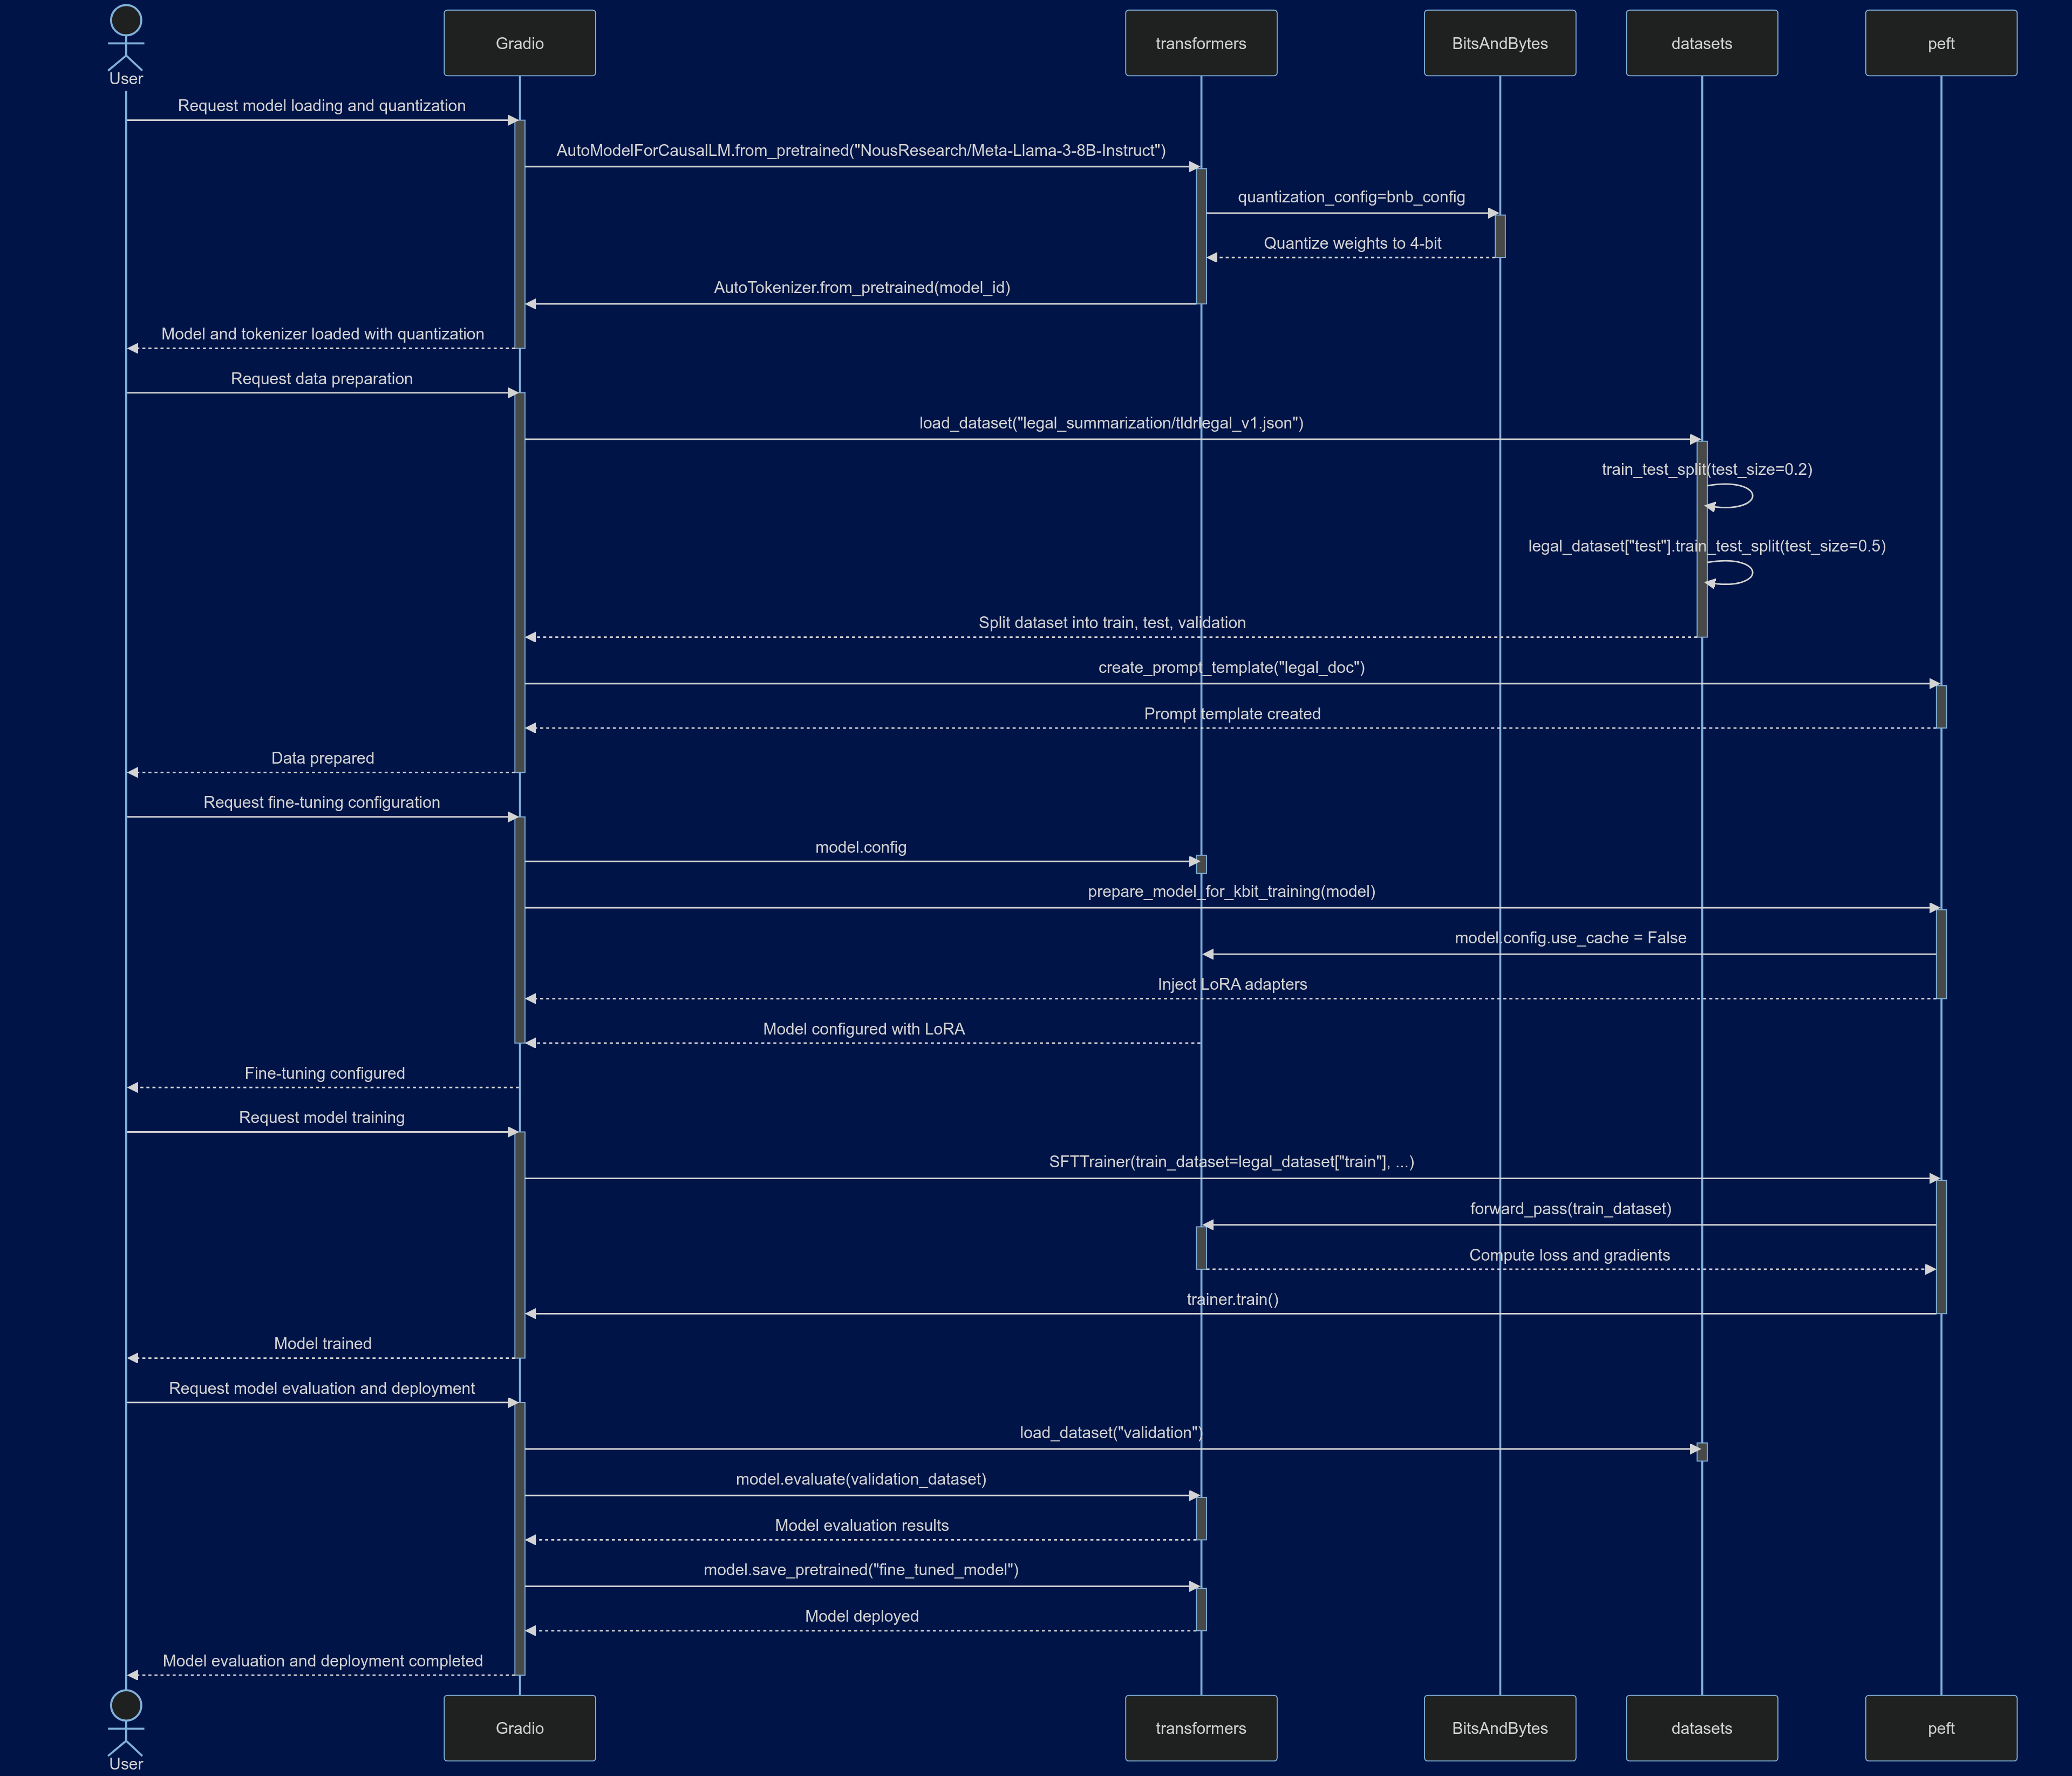

#### ❓Question #1:

What makes Llama 3 8B Instruct a good model to use for a summarization task?

##### ANSWER:
1. **Instruction Tuning:**
   - **Explanation:** Llama 3 8B Instruct has been specifically trained to follow instructions, making it better suited for summarization tasks that require adherence to specific guidelines and prompts. Instruction tuning helps the model understand and execute complex directives, resulting in more accurate and coherent summaries.
   - **Benefit:** This makes the model highly effective for tasks that involve summarization, where following specific instructions is crucial to generate relevant and concise outputs.

2. **Model Size:**
   - **Explanation:** The 8B model balances computational cost and performance. It is large enough to capture the nuances and complexity needed for high-quality summarization but not so large that it becomes impractical for single-GPU training or deployment.
   - **Benefit:** This balance ensures that the model is powerful enough to handle complex summarization tasks while remaining feasible to use in a variety of settings, including those with limited computational resources.

3. **Llama Family's Strengths:**
   - **Explanation:** The Llama models, developed by Meta, are known for their strong performance in various language tasks. The architecture and training methodologies used in the Llama family make them particularly adept at understanding and generating human-like text.
   - **Benefit:** Leveraging the strengths of the Llama family, Llama 3 8B Instruct is a reliable choice for summarization, benefiting from the advancements and robust performance characteristics inherent to this model lineage.

4. **Dataset Specificity:**
   - **Explanation:** The use of the samsum dataset, which is specifically designed for summarizing dialogue conversations, enhances the model's performance by providing relevant and high-quality training data. This dataset helps the model learn to generate summaries that are coherent and contextually appropriate for dialogue-based inputs.
   - **Benefit:** Using a specialized dataset like samsum ensures that the model is well-trained on the nuances of dialogue summarization, leading to more accurate and contextually relevant summaries in real-world applications.

5. **Fine-Tuning Recipes:**
   - **Explanation:** Meta provides detailed fine-tuning recipes and guidelines for Llama models, including Llama 3 8B Instruct. These recipes help in effectively adapting the model to specific tasks, such as summarization, by providing best practices and optimization techniques.
   - **Benefit:** Access to well-documented fine-tuning procedures allows users to maximize the model’s performance on summarization tasks, ensuring efficient and effective adaptation to specific datasets and requirements.

**Additional Context:**

- **Source:** More details about the fine-tuning process and best practices can be found in Meta's Llama recipes repository: [Meta Llama Recipes](https://github.com/meta-llama/llama-recipes/tree/main/recipes/finetuning).

### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

# 🤝 Breakout Room #1

### Setting Up Dependencies

We'll start by setting up the dependencies!

In [ ]:
!pip install -qU bitsandbytes datasets accelerate loralib peft transformers trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 73.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that 

We'll first verify we're in a GPU instance.

In [ ]:
import torch
torch.cuda.is_available()

True

Time to import some dependencies!

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 40GB GPU.
- `bnb_4bit_quant_type` - setting this to the desired format of `nf4` will ensure we're using the most memory efficient datatype for 4bit storage.
- `bnb_double_quant` - setting this to true will save us memory by quantizing the quantization config
- `bnb_4bit_compute_dtype` - since we will not use a 4-bit representation to compute, we need to provide a desired format for our compute type so our weights can be upcast to something while we flow information through our network.



In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

#### ❓Question #2:

What exactly is happening in the double quantization step?

> NOTE: You can use the paper provided to find the answer!

##### ANSWER:
**Double quantization** is a two-step process aimed at reducing memory usage while preserving model performance during fine-tuning. The process is detailed in the QLoRA paper and involves the following steps:

1. **Initial Quantization:**
   - The model is first quantized to 4 bits using a method called 4-bit NormalFloat (NF4). This significantly reduces the memory footprint of the model by converting the original 16-bit or 32-bit floating-point weights to 4-bit precision.
   - This step reduces the memory usage by a factor of 4 to 8, depending on the original precision of the weights.

2. **Second Quantization (Double Quantization):**
   - After the initial 4-bit quantization, a secondary quantization is applied to the quantization constants themselves. This means that the quantization scales and zero points used in the first quantization step are also quantized to further reduce the memory overhead.
   - By quantizing these quantization constants, the memory footprint is further decreased, which helps in managing memory more efficiently and potentially enhances the accuracy of the quantized model.

**Key Innovations in QLoRA:**
- **4-bit NormalFloat (NF4):** This new data type is optimized for normally distributed weights, which are common in pre-trained language models. NF4 provides a good balance between precision and memory savings.
- **Paged Optimizers:** These are used to manage memory spikes during training, ensuring that the memory usage remains within the limits of available GPU memory.
- **Low Rank Adapters (LoRA):** Gradients are backpropagated through a frozen, 4-bit quantized pre-trained language model into LoRA. This allows fine-tuning with a significantly reduced memory footprint while preserving performance.

**Detailed Process:**
- **Quantization of Weights:** The original model weights are first converted to 4-bit precision using NF4.
- **Quantization of Quantization Constants:** The scales and zero points used in the initial quantization are themselves quantized, effectively applying a second layer of quantization.

**Benefits of Double Quantization:**
- **Memory Efficiency:** Double quantization allows the fine-tuning of very large models (e.g., 65B parameters) on a single 48GB GPU, which would be infeasible with regular fine-tuning methods.
- **Performance Preservation:** Despite the aggressive quantization, QLoRA preserves the performance of full 16-bit fine-tuning, making it an effective approach for large-scale model adaptation.
- **Scalability:** This method enables the fine-tuning of models of various sizes, from smaller models to very large models, without sacrificing performance.

**Example from the QLoRA Paper:**
- The QLoRA approach was used to fine-tune the Guanaco model family, which achieved state-of-the-art performance on several benchmarks, demonstrating the effectiveness of double quantization in practical applications.

**Reference:**
- For more details, refer to the QLoRA paper: [Efficient Finetuning of Large-Scale Language Models](https://arxiv.org/abs/2305.14314).

### Summary

Double quantization in QLoRA involves an initial 4-bit quantization of model weights followed by a secondary quantization of the quantization constants. This process significantly reduces memory usage while preserving the performance of fine-tuning tasks, enabling efficient adaptation of large models on limited hardware resources.

Now we can load the model.

In [ ]:
model_id = "NousResearch/Meta-Llama-3-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

### Model Architecture

It's important to observe the model's construction!

This one should look familiar!

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

In [ ]:
model.config

LlamaConfig {
  "_name_or_path": "NousResearch/Meta-Llama-3-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
 

#### ❓Question #3:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `NousResearch/Meta-Llama-3-8B-Instruct`'s architecture.

- EXAMPLE - Layer Norm:
  - `(input_layernorm): LlamaRMSNorm()`
  - `(post_attention_layernorm): LlamaRMSNorm()`
  - `(norm): LlamaRMSNorm()`
- Feed Forward:
- Masked Multi Self-Attention:
- Text & Position Embed:
- Text Prediction:

##### ANSWER:

** Model Architecture for `LlamaForCausalLM`: **

1. **`embed_tokens`:** `Embedding(128256, 4096)`
   - Embedding layer converting token indices to dense vectors of size 4096.

2. **`layers`:** `ModuleList(0-31): 32 x LlamaDecoderLayer`
   - A stack of 32 `LlamaDecoderLayer` instances.

3. **Within each `LlamaDecoderLayer`:**
   - **`self_attn`:** `LlamaSdpaAttention`
     - **`q_proj`:** `Linear4bit(in_features=4096, out_features=4096, bias=False)`
       - Projects the input to query vectors.
     - **`k_proj`:** `Linear4bit(in_features=4096, out_features=1024, bias=False)`
       - Projects the input to key vectors.
     - **`v_proj`:** `Linear4bit(in_features=4096, out_features=1024, bias=False)`
       - Projects the input to value vectors.
     - **`o_proj`:** `Linear4bit(in_features=4096, out_features=4096, bias=False)`
       - Projects the output of the attention mechanism back to the model dimension.
     - **`rotary_emb`:** `LlamaRotaryEmbedding`
       - Applies rotary position embeddings to the queries and keys.

   - **`mlp`:** `LlamaMLP`
     - **`gate_proj`:** `Linear4bit(in_features=4096, out_features=14336, bias=False)`
       - First linear layer in the MLP, often serving as a gating mechanism.
     - **`up_proj`:** `Linear4bit(in_features=4096, out_features=14336, bias=False)`
       - Expands the input dimension in the MLP.
     - **`down_proj`:** `Linear4bit(in_features=14336, out_features=4096, bias=False)`
       - Reduces the dimension back to the model size.
     - **`act_fn`:** `SiLU`
       - Activation function used in the MLP.

   - **`input_layernorm`:** `LlamaRMSNorm`
     - Layer normalization applied before the self-attention mechanism.
   - **`post_attention_layernorm`:** `LlamaRMSNorm`
     - Layer normalization applied after the self-attention mechanism.

4. **`norm`:** `LlamaRMSNorm`
   - Final layer normalization applied before the output layer.

5. **`lm_head`:** `Linear(in_features=4096, out_features=128256, bias=False)`
   - The final linear layer that projects the model output to the vocabulary size for token prediction.

##### Answer for Question #3:

Based on the correct model architecture:

- **(input_layernorm):** `LlamaRMSNorm`
  - Layer normalization before the self-attention mechanism.
- **(post_attention_layernorm):** `LlamaRMSNorm`
  - Layer normalization after the self-attention mechanism.
- **(norm):** `LlamaRMSNorm`
  - Final layer normalization before the output layer.
- **Feed Forward:** `LlamaMLP`
  - The multi-layer perceptron consisting of `gate_proj`, `up_proj`, and `down_proj` with `SiLU` activation.
- **Masked Multi Self-Attention:** `LlamaSdpaAttention`
  - Self-attention mechanism with `q_proj`, `k_proj`, `v_proj`, `o_proj`, and `rotary_emb`.
- **Text & Position Embed:** The combination of `embed_tokens` and `rotary_emb`
  - The embedding layer and rotary position embeddings.
- **Text Prediction:** `lm_head`
  - The final linear layer for token prediction.

# 🤝 Breakout Room #2

## Task #2: Data and Data Preparation

Since we'll be focusing on summarization fine-tuning - we'll need to find a summarization dataset!

There are a few good examples available to use on the Hugging Face [dataset](https://huggingface.co/datasets?task_categories=task_categories:summarization&sort=trending) hub - let's check a few of them out!

> NOTE: The link above is pre-filtered to include datasets with the summarization tag

### Summarization Datasets

Let's see what is available for us:

- [`databricks/databricks-dolly-15k`](https://huggingface.co/datasets/databricks/databricks-dolly-15k)
  - this dataset is comprised of ~15K rows of various tasks of which ~7% is summarization data
- [`samsum`](https://huggingface.co/datasets/samsum)
  - this dataset contains ~16K conversations in messenger format as well as their summaries
- [`CohereForAI/aya_collection`](https://huggingface.co/datasets/CohereForAI/aya_collection)
  - similar to Dolly-15K, this dataset contains a wide range of *multilingual* tasks - a subset of which is summarization
- [`Plain English Summary of Contracts`](https://github.com/lauramanor/legal_summarization)
  - contains legal document (EULA, TOS, etc) and natural language summary pairs.

Today we'll be using the Plain English Summary of Contracts dataset to fine-tune Llama 3 8B Instruct to provide natural language descriptions of Legal Documents!

The first step will be to download the dataset from GitHub!

In [ ]:
!git clone https://github.com/lauramanor/legal_summarization

Cloning into 'legal_summarization'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 31 (delta 2), reused 0 (delta 0), pack-reused 25
Receiving objects: 100% (31/31), 136.60 KiB | 6.21 MiB/s, done.
Resolving deltas: 100% (10/10), done.


Then we can load it into a list of JSON objects.

In [ ]:
import json

jsonl_array = []

with open('legal_summarization/tldrlegal_v1.json') as f:
  data = json.load(f)
  for key, value in data.items():
    jsonl_array.append(value)

Finally we can convert our list of JSON objects to a dataset quickly and effectively using the Hugging Face [`datasets`](https://huggingface.co/docs/datasets/en/index) library!

In [ ]:
from datasets import Dataset, load_dataset

legal_dataset = Dataset.from_list(jsonl_array)

Let's check how many items we have in each of our training, validation, and test subsets.

In [ ]:
legal_dataset

Dataset({
    features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
    num_rows: 85
})

We can now format our dataset into a training test split!

In [ ]:
legal_dataset = legal_dataset.train_test_split(test_size=0.2)

In [ ]:
legal_dataset_test_valid = legal_dataset["test"].train_test_split(test_size=0.5)

In [ ]:
from datasets import DatasetDict

legal_dataset = DatasetDict({
    "train" : legal_dataset["train"],
    "test" : legal_dataset_test_valid["test"],
    "validation" : legal_dataset_test_valid["train"]
})

In [ ]:
legal_dataset

DatasetDict({
    train: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 68
    })
    test: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['doc', 'id', 'original_text', 'reference_summary', 'title', 'uid'],
        num_rows: 8
    })
})

Let's look at a single example to see the format we're working with!

In [ ]:
legal_dataset["train"][0]

{'doc': 'Pokemon GO Terms of Service',
 'id': '57866df76cca83a54c0035a1',
 'original_text': 'by using our services you are agreeing to these terms our trainer guidelines and our privacy policy. if you are the parent or legal guardian of a child under the age of 13 the parent you are agreeing to these terms on behalf of yourself and your child ren who are authorized to use the services pursuant to these terms and in our privacy policy. if you don t agree to these terms our trainer guidelines and our privacy policy do not use the services.',
 'reference_summary': 'by playing this game you agree to these terms. if you re under 13 and playing your parent guardian agrees on your behalf.',
 'title': 'Agreement To Terms',
 'uid': 'legalsum02'}

##### COMMENTS ON UPLOADING TRAIN / TEST / VAL SPLITS TO HF

```python
import huggingface_hub
from datasets import DatasetDict, load_dataset

# Step 1: Install Required Libraries (run this in your terminal or notebook cell)
# !pip install datasets huggingface_hub

# Step 2: Login to Hugging Face Hub (run this in your terminal or notebook cell)
# huggingface_hub.login()

# Step 3: Load and Prepare the Dataset
# Load your dataset
legal_dataset = load_dataset("path_to_your_local_dataset")  # Update with your dataset path

# Create train, validation, and test splits
legal_dataset = DatasetDict({
    "train" : legal_dataset["train"],
    "test" : legal_dataset_test_valid["test"],
    "validation" : legal_dataset_test_valid["train"]
})

# Step 4: Push the Dataset to Hugging Face Hub
legal_dataset.push_to_hub("dwb2023/legal_dataset", version="v1.0")
```

### Instruction Templating

Instruction-tuned LLMs will typically use a specific template when being trained to accomodate various instruction sets, as well as for better chat and multi-turn use-cases.

Here is the format as indicated in Meta's [llama3](https://github.com/meta-llama/llama3?tab=readme-ov-file#instruction-tuned-models) repository, as well as the intuition behind the prompt template.

> The fine-tuned models were trained for dialogue applications. To get the expected features and performance for them, a specific formatting defined in ChatFormat needs to be followed: The prompt begins with a `<|begin_of_text|>` special token, after which one or more messages follow. Each message starts with the `<|start_header_id|>` tag, the role `system`, `user` or `assistant`, and the `<|end_header_id|>` tag. After a double newline `"\n\n"` the contents of the message follow. The end of each message is marked by the `<|eot_id|>` token.

Here is an example of this format:

```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]
welcome to the pokémon go video game services which are accessible via the niantic inc niantic mobile device application the app. to make these pokémon go terms of service the terms easier to read our video game services the app and our websites located at http pokemongo nianticlabs com and http www pokemongolive com the site are collectively called the services. please read carefully these terms our trainer guidelines and our privacy policy because they govern your use of our services.
[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>

hi.<|eot_id|>
```

> NOTE: We're adding our own special tokens here in `[LEGAL_DOC]` and `[END_LEGAL_DOC]` to encourage the model to better understand our context, but these are not special tokens that are already understood by the model.

#### 🏗️ Activity #1: Creating the `create_prompt` function

We'll create a function that will take a row of our dataset, along with a default False flag that creates the prompt in the format expressed above.

##### IMPORTANT
Meta Llama 3 has a new prompt template and special tokens (based on the tiktoken tokenizer).

| Token | Description |
|---|---|
`<\|begin_of_text\|>` | This is equivalent to the BOS token. |
`<\|end_of_text\|>` | This is equivalent to the EOS token. For multiturn-conversations it's usually unused. Instead, every message is terminated with `<\|eot_id\|>` instead.|
`<\|eot_id\|>` | This token signifies the end of the message in a turn i.e. the end of a single message by a system, user or assistant role as shown below.|
`<\|start_header_id\|>{role}<\|end_header_id\|>` | These tokens enclose the role for a particular message. The possible roles can be: system, user, assistant. |

A multiturn-conversation with Meta Llama 3 follows this prompt template:
```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
{{ system_prompt }}<|eot_id|><|start_header_id|>user<|end_header_id|>
{{ user_message_1 }}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
{{ model_answer_1 }}<|eot_id|><|start_header_id|>user<|end_header_id|>
{{ user_message_2 }}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
```
Each message gets trailed by an `<|eot_id|>` token before a new header is started, signaling a role change.

More details on the new tokenizer and prompt template can be found [here](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3#special-tokens-used-with-meta-llama-3).

SOURCE:  [meta-llama/llama-recipes](https://github.com/meta-llama/llama-recipes/blob/main/README.md)

In [ ]:
INSTRUCTION_PROMPT_TEMPLATE = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]
{legal_doc}
[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

RESPONSE_TEMPLATE = """
{summary}<|eot_id|>
"""

In [ ]:
def create_prompt(sample, include_response=True):
    """
    Parameters:
        - sample: dict representing row of dataset
        - include_response: bool
    Functionality:
        This function should build the Python str `full_prompt`.
        If `include_response` is true, it should include the summary -
        else it should not contain the summary (useful for prompting) and testing
    Returns:
        - full_prompt: str
    """
    full_prompt = INSTRUCTION_PROMPT_TEMPLATE.format(legal_doc=sample["original_text"])

    if include_response:
        full_prompt += RESPONSE_TEMPLATE.format(summary=sample["reference_summary"])

    return full_prompt

In [ ]:
print(create_prompt(legal_dataset["test"][1]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Please convert the following legal content into a human-readable summary<|eot_id|><|start_header_id|>user<|end_header_id|>

[LEGAL_DOC]
if you have third party advertising in your api client which is provided by a google advertising solution you must use an approved third party ad serving 3pas provider subject to google s current 3pas policies at http adwords google com support aw bin answer py hl en answer 94230.
[END_LEGAL_DOC]<|eot_id|><|start_header_id|>assistant<|end_header_id|>

if you use third party advertising it must be 3pas compliant.<|eot_id|>



In [ ]:
def generate_response(prompt, model, tokenizer):
  """
  Parameters:
    - prompt: str representing formatted prompt
    - model: model object
    - tokenizer: tokenizer object

  Functionality:
    This will allow our model to generate a response to a prompt!

  Returns:
    - str response of the model
  """

  # convert str input into tokenized input
  encoded_input = tokenizer(prompt,  return_tensors="pt")

  # send the tokenized inputs to our GPU
  model_inputs = encoded_input.to('cuda')

  # generate response and set desired generation parameters
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=256,
      do_sample=True,
      pad_token_id=tokenizer.eos_token_id
  )

  # decode output from tokenized output to str output
  decoded_output = tokenizer.batch_decode(generated_ids)

  # return only the generated response (not the prompt) as output
  return decoded_output[0].split("<|end_header_id|>")[-1]

In [ ]:
generate_response(create_prompt(legal_dataset["test"][1], include_response=False),
                  model,
                  tokenizer)

'\nHere is a human-readable summary of the legal content:\n\n"If you use third-party advertising in your API client that is provided by a Google advertising solution, you must use an approved third-party ad serving provider that complies with Google\'s current 3PAS (Third-Party Ad Serving) policies. You can find more information about these policies at [http://adwords.google.com/support/aw/bin/answer.py?hl=en&answer=94230](http://adwords.google.com/support/aw/bin/answer.py?hl=en&answer=94230)."<|eot_id|>'

In [ ]:
# Ground Truth Summary
legal_dataset["test"][1]["reference_summary"]

'if you use third party advertising it must be 3pas compliant.'

Let's try another just to see how the model responds to a different prompt.

In [ ]:
generate_response(create_prompt(legal_dataset["test"][3], include_response=False),
                  model,
                  tokenizer)

"\nHere's a human-readable summary:\n\nBy using the SDK, you agree to use it only for purposes that are allowed by the license agreement and any relevant laws, regulations, or industry standards in your jurisdiction. This includes any restrictions on exporting data or software from the United States or other countries.<|eot_id|>"

In [ ]:
# Ground Truth Summary
legal_dataset["test"][3]["reference_summary"]

'stay within the law and license agreement.'

The response, while an accurate *recounting* of the conversation is certainly not what would be consider to be a summary.

Let's see how fine-tuning can improve these responses.

### Required Post Processing

Finally, we need to apply some post-processing on the 4-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

Instead of doing this manually, of course, we can use the helper function `prepare_model_for_kbit_training`! You can look at the source code [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/utils/other.py#L67)

In [ ]:
from peft import prepare_model_for_kbit_training
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)

## Task #3: Setting up PEFT LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

#### Helper Function to Print Parameter %age

This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

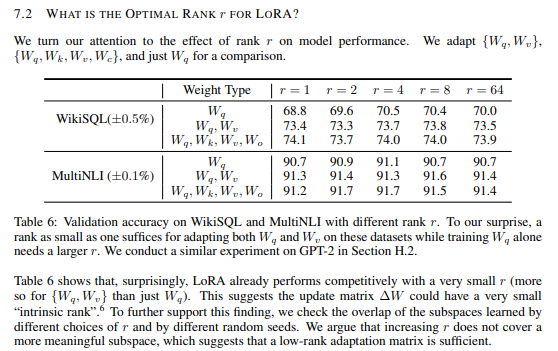


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

In [ ]:
from peft import LoraConfig, get_peft_model

# set our rank (higher value is more memory/better performance)
lora_r = 16

# set our dropout (default value)
lora_dropout = 0.1

# rule of thumb: alpha should be (lora_r * 2)
lora_alpha = 32

# construct our LoraConfig with the above hyperparameters
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM"
)

Now that we have our PEFT config - we need to convert our model into a PEFT model!

We can use the convenient helper function `get_peft_model` to do so.

Documentation found [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/mapping.py#L98)!

In [ ]:
model = get_peft_model(
    model,
    peft_config
)

print_trainable_parameters(model)

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4

#### ❓Question #4:

What modules (or groupings of layers) did we apply LoRA too - and how can we tell from the model summary?

##### ANSWER:

In the fine-tuning process using LoRA, specific layers of the model are targeted for adaptation to ensure efficient fine-tuning. based on the `LoraConfig`.

### **1. LoRA Configuration:**

The `LoraConfig` specifies parameters such as rank (`r`), dropout (`lora_dropout`), scaling factor (`lora_alpha`), and target modules (`target_modules`). Here’s how these parameters influence which parts of the model LoRA is applied to:

### **2. Model Summary and LoRA Layers:**

The application of LoRA involves injecting `lora_A` and `lora_B` matrices into specified linear layers of the model. These matrices are used to perform the low-rank adaptation. In the provided model summary, you can identify the presence of LoRA by looking for these matrices within specific modules.

### **Identifying LoRA Layers:**

From the model summary:
- **Self-Attention Layers (`q_proj`, `k_proj`, `v_proj`, `o_proj`):**
  - These layers contain `lora.Linear4bit` components, with `lora_A` and `lora_B` matrices indicating where LoRA was applied.
  - The dropout layers (`lora_dropout`) and embedding parameters (`lora_embedding_A`, `lora_embedding_B`) are part of the LoRA configuration.

- **MLP Layers (`gate_proj`, `up_proj`, `down_proj`):**
  - These layers also use `lora.Linear4bit` components, with similar `lora_A` and `lora_B` matrices, dropout layers, and embedding parameters.

### **Summary for Question #4:**

**Modules Applied LoRA to:**
- The self-attention layers (`q_proj`, `k_proj`, `v_proj`, `o_proj`).
- The MLP layers (`gate_proj`, `up_proj`, `down_proj`).

**How to Tell from Model Summary:**
- Presence of `lora.Linear4bit` components in these layers.
- Identification of `lora_A` and `lora_B` matrices within these layers.
- Specific configuration settings in `LoraConfig` that target these modules (`target_modules="all-linear"`).

## Task #4: Training the Model

Now we'll be training our model with the created dataset!



### Setting up Training

The `SFTConfig` class contains all the usual suspects - these are the same hyper-parameters you know and love from from previous notebooks!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [ ]:
from trl import SFTConfig

max_seq_length = 1024

args = SFTConfig(
  output_dir = "llama38binstruct_summarize",
  #num_train_epochs=5,
  max_steps = 100, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 1,
  warmup_steps = 0.03,
  logging_steps=10,
  #evaluation_strategy="epoch",
  eval_strategy="steps",
  eval_steps=25, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2e-4,
  lr_scheduler_type='constant',
  dataset_kwargs={
        "add_special_tokens" : False,
        "append_concat_token" : False,
  },
  max_seq_length=max_seq_length,
  packing=True,
)

#### ❓Question #5:

Describe what the following parameters are doing:

- `warmup_steps`
- `learning_rate`
- `lr_scheduler_type`

> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

##### ANSWER:
* **`warmup_steps`:**  During training, the learning rate is often increased gradually over a period of steps called the "warmup" phase. This helps to prevent instability at the start of training. `warmup_steps` specifies the number of steps in this phase.
* **`learning_rate`:** This parameter is the starting learning rate for the optimizer. This controls how much the weights change during each training step.
* **`lr_scheduler_type`:** The learning rate scheduler controls how the learning rate changes over the course of training.
    * `linear` means the learning rate decreases linearly over the course of training.
    * `cosine` means the learning rate follows a cosine curve (and often performs better).

> **Documentation**: You can find more details about these parameters and other training hyperparameters in the [Hugging Face Transformers `TrainingArguments` documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)

The merge_and_unload() method merges the LoRA adapter weights into the base model and unloads the adapter, resulting in:

1. Faster Inference: No need to load the LoRA adapter separately.
2. Simplified Deployment: Easier to deploy a single, merged model.

This method is described in the [trl documentation](https://huggingface.co/docs/trl/v0.7.11/use_model).

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  tokenizer=tokenizer,
  formatting_func=create_prompt,
  args=args,
  train_dataset=legal_dataset["train"],
  eval_dataset=legal_dataset["validation"]
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:486: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


> NOTE: The following cell should take ~45min. or so to complete on a T4 GPU with the pre-set hyper-parameters.

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.407900,1.432510
50,0.393500,1.678639
75,0.383600,1.769380
100,0.103900,2.084696


TrainOutput(global_step=100, training_loss=0.695325608253479, metrics={'train_runtime': 543.2315, 'train_samples_per_second': 0.184, 'train_steps_per_second': 0.184, 'total_flos': 4636795522252800.0, 'train_loss': 0.695325608253479, 'epoch': 4.761904761904762})

##### COMMENTS ON TRAINING & VALIDATION LOSS:
There are several reasons why you might observe a disparity between training loss and validation loss during the training process of a model. Here are some common reasons:

1. **Overfitting**:
   - **Explanation**: When a model performs well on the training data but poorly on the validation data, it is often a sign of overfitting. This means the model has learned the training data too well, including its noise and outliers, and has not generalized well to unseen data.
   - **Indication**: A consistently decreasing training loss with an increasing validation loss, as seen in your results, often indicates overfitting.

2. **Model Complexity**:
   - **Explanation**: A very complex model (with a large number of parameters) can memorize the training data easily but fail to generalize to new data.
   - **Indication**: If the model has many layers or parameters and is not regularized properly, it may fit the training data perfectly but struggle with validation data.

3. **Data Imbalance**:
   - **Explanation**: If the training data and validation data are not representative of each other, this can cause a disparity. For example, if the training data is much simpler or has fewer variations than the validation data.
   - **Indication**: If the validation loss is consistently higher than the training loss, it could mean that the validation data has more complex patterns or different distributions compared to the training data.

4. **Insufficient Regularization**:
   - **Explanation**: Regularization techniques like dropout, L2 regularization, or data augmentation help prevent overfitting. Without sufficient regularization, the model might perform very well on the training data but poorly on the validation data.
   - **Indication**: High variance between training and validation losses often suggests a need for more regularization.

5. **Early Stopping**:
   - **Explanation**: Training for too many epochs can lead to overfitting. Using early stopping based on validation loss can help mitigate this.
   - **Indication**: If the validation loss starts increasing after a certain point while the training loss continues to decrease, early stopping should be considered.

6. **Batch Size and Learning Rate**:
   - **Explanation**: Small batch sizes can lead to noisy updates, while large batch sizes might not capture the generalization well. Similarly, a too high learning rate might cause the model to overshoot minima, while a too low learning rate might cause it to get stuck in local minima.
   - **Indication**: Improper batch size or learning rate can also contribute to the disparity between training and validation losses.

7. **Data Leakage**:
   - **Explanation**: If some of the validation data is inadvertently used in training, it can give misleadingly good training loss and poor validation loss.
   - **Indication**: This can happen if there's a mix-up in data preprocessing steps or if the data is not properly partitioned.

### Analysis of Your Results
From your provided results:

- **Training Loss**: Decreases consistently from 1.455100 to 0.113800.
- **Validation Loss**: Increases from 1.643615 to 1.873935.

This suggests that the model is overfitting the training data as it is learning the training data very well (training loss decreasing) but is not generalizing to the validation data (validation loss increasing).

### Possible Solutions
1. **Regularization**:
   - Increase dropout rates or add L2 regularization.
   - Use techniques like data augmentation to increase the diversity of the training data.

2. **Early Stopping**:
   - Implement early stopping based on validation loss to prevent overfitting.

3. **Simplify the Model**:
   - Reduce the complexity of the model (fewer layers or parameters) to avoid overfitting.

4. **Balanced Data**:
   - Ensure the training and validation data are representative of each other.

5. **Adjust Hyperparameters**:
   - Experiment with different learning rates and batch sizes to find a better balance.

### Conclusion
Addressing the disparity between training and validation loss often requires a combination of the above techniques. By carefully monitoring both training and validation metrics and adjusting the training process accordingly, you can improve the model's generalization and overall performance.

## Task #5: Share Your Model!

Normally, we would only seek to push the LoRA adapters to the hub. This is a lightweight and memory efficient way to push this model - as you can pull the base model down as part of the inference pipeline.

However, if you want to leverage the one-click-deploy features of Hugging Face, you'll need to first `merge_and_unload()` the model and push the resulting model to the hub. This process will merge the LoRA weights back into the base model.

> NOTE: If you run into issues during upload - please ensure you're using a HF Token with `WRITE` access!

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub("dwb2023/llama38binstruct_summarize")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

events.out.tfevents.1718268154.19d0f881613b.3120.0:   0%|          | 0.00/9.24k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dwb2023/llama38binstruct_summarize/commit/bee5696f7e49dd185b7cef5dad5786c5e93fc117', commit_message='dwb2023/llama38binstruct_summarize', commit_description='', oid='bee5696f7e49dd185b7cef5dad5786c5e93fc117', pr_url=None, pr_revision=None, pr_num=None)

### Compare Outputs

Let's see how our model fairs at this task, now!

In [ ]:
merged_model = model.merge_and_unload()
output_dir = "llama38binstruct_summarize"
merged_model.save_pretrained(output_dir)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


#### ❓Question #6:

> Add blockquote



What does the `merge_and_unload()` method do?

> NOTE: Check out the [documentation](https://huggingface.co/docs/trl/v0.7.11/use_model) or the [source code](https://github.com/huggingface/peft/blob/096fe537370cf8a2cb55cc9bd05c7812ca919405/src/peft/tuners/lora/model.py#L685) to find out!

##### ANSWER:

The merge_and_unload() method merges the LoRA adapter weights into the base model and unloads the adapter, resulting in:

1. Faster Inference: No need to load the LoRA adapter separately.
2. Simplified Deployment: Easier to deploy a single, merged model.

Learning the difference between a couple of similar sounding parameters was important (output directory for merged model VS push to hub endpoint)

ALSO... interaction and relationship between the following commands:
- trainer.push_to_hub()
- model.merge_and_unload()

In [ ]:
generate_response(create_prompt(legal_dataset["test"][1], include_response=False),
                  merged_model,
                  tokenizer)

'\nHere is a human-readable summary of the legal content:\n\n"If you use third-party advertising in your API client through a Google advertising solution, you must use an approved third-party ad serving provider that complies with Google\'s current 3PAS (Third-Party Ad Serving) policies, which can be found at http://adwords.google.com/support/bin/answer.py?hl=en&answer=94230."<|eot_id|>'

Let's look at the base model response:

> *When you use our services, you agree to protect Niantic, TPC, and their employees from any claims, disputes, or lawsuits that might arise from your use of our services, the content we provide, or your own content. This includes any legal or accounting fees we might incur as a result. This means that if something goes wrong, you\'ll be responsible for paying for any damages or losses, including legal fees.*

Now the fine-tuned response:

> *By using Niantic's services, you agree to protect Niantic, its officers, directors, employees, and agents from any claims, disputes, or losses that may arise from your use of the services, your content, or if you violate these terms.*



We can see that, directionally, our model is getting much closer to our desired results with only *100* steps of training.

Let's try another example to make sure it wasn't a fluke!

In [ ]:
generate_response(create_prompt(legal_dataset["test"][3], include_response=False),
                  merged_model,
                  tokenizer)

'\nHere is a human-readable summary:\n\nBy using the SDK, you agree to use it only for purposes that are allowed by the license agreement and any applicable laws, regulations, or industry standards in the relevant jurisdictions. This includes any laws related to the export of data or software to and from the United States or other countries.<|eot_id|>'

In [ ]:
# Ground Truth Summary
legal_dataset["test"][3]["reference_summary"]

'stay within the law and license agreement.'

Lets look at the base model response:

>  *When you use Google Play Game Services, you agree to protect Google and its related companies, officers, agents, and employees from any claims or lawsuits that might arise from your misuse of the service, your failure to follow these terms, or the actions of a third party who uses the service. This includes any liability or expense resulting from claims, losses, damages, or lawsuits, including attorney's fees.\n\nIf such a claim or lawsuit arises, Google will notify you in writing.*

And the fine-tuned model:

> *When you use Google Play Game Services, you agree to protect Google and its affiliates from any legal claims that might arise from your misuse of the service, your violation of these terms, or the actions of third-party developers who use the service. This means that if someone sues Google because of something you did or didn't do, you'll be responsible for any damages, losses, or legal fees. Google will notify you in writing if this happens.*

And again, we can see that the model performs the task *better* than the original un-fine-tuned model, in that the language is less formal - though there is still work to do.

## Mermaid.js Model format

```mermaid
sequenceDiagram
    actor User
    participant Gradio
    participant transformers
    participant bitsandbytes as BitsAndBytes
    participant datasets
    participant peft

    %% Model Loading and Quantization
    User ->> Gradio: Request model loading and quantization
    activate Gradio
    Gradio ->> transformers: AutoModelForCausalLM.from_pretrained("NousResearch/Meta-Llama-3-8B-Instruct")
    activate transformers
    transformers ->> bitsandbytes: quantization_config=bnb_config
    activate bitsandbytes
    bitsandbytes -->> transformers: Quantize weights to 4-bit
    deactivate bitsandbytes
    transformers ->> Gradio: AutoTokenizer.from_pretrained(model_id)
    deactivate transformers
    Gradio -->> User: Model and tokenizer loaded with quantization
    deactivate Gradio
    

    %% Data Preparation
    User ->> Gradio: Request data preparation
    activate Gradio
    Gradio ->> datasets: load_dataset("legal_summarization/tldrlegal_v1.json")
    activate datasets
    datasets ->> datasets: train_test_split(test_size=0.2)
    datasets ->> datasets: legal_dataset["test"].train_test_split(test_size=0.5)
    datasets -->> Gradio: Split dataset into train, test, validation
    deactivate datasets
    Gradio ->> peft: create_prompt_template("legal_doc")
    activate peft
    peft -->> Gradio: Prompt template created
    deactivate peft
    Gradio -->> User: Data prepared
    deactivate Gradio
    

    %% Fine-Tuning Configuration
    User ->> Gradio: Request fine-tuning configuration
    activate Gradio
    Gradio ->> transformers: model.config
    activate transformers
    deactivate transformers
    Gradio ->> peft: prepare_model_for_kbit_training(model)
    activate peft
    peft ->> transformers: model.config.use_cache = False
    peft -->> Gradio: Inject LoRA adapters
    deactivate peft
    transformers -->> Gradio: Model configured with LoRA
    deactivate Gradio
    Gradio -->> User: Fine-tuning configured
    

    %% Training
    User ->> Gradio: Request model training
    activate Gradio
    Gradio ->> peft: SFTTrainer(train_dataset=legal_dataset["train"], ...)
    activate peft
    peft ->> transformers: forward_pass(train_dataset)
    activate transformers
    transformers -->> peft: Compute loss and gradients
    deactivate transformers
    peft ->> Gradio: trainer.train()
    deactivate peft
    Gradio -->> User: Model trained
    deactivate Gradio

    %% Evaluation and Deployment
    User ->> Gradio: Request model evaluation and deployment
    activate Gradio
    Gradio ->> datasets: load_dataset("validation")
    activate datasets
    deactivate datasets
    Gradio ->> transformers: model.evaluate(validation_dataset)
    activate transformers
    transformers -->> Gradio: Model evaluation results
    deactivate transformers
    Gradio ->> transformers: model.save_pretrained("fine_tuned_model")
    activate transformers
    transformers -->> Gradio: Model deployed
    deactivate transformers
    Gradio -->> User: Model evaluation and deployment completed
    deactivate Gradio
    ```


## My Evolving Understanding...

The final model architecture for `LlamaForCausalLM` after merging the LoRA adjustments will be structurally identical to the original pre-trained model architecture. The key differences lie in the updated weights that result from the LoRA fine-tuning process.

To summarize:

1. The overall structure of the model, including the number of layers, types of sub-modules, and their configurations, remains the same before and after LoRA fine-tuning and merging.

2. The primary change occurs in the weights of the linear layers and other learnable parameters. During the LoRA fine-tuning process, the `lora_A` and `lora_B` matrices capture the fine-tuning adjustments. When `merge_and_unload` is called, these adjustments are merged into the original model weights, effectively updating them to reflect the fine-tuning.

3. After merging, the separate LoRA components (`lora_A`, `lora_B`, `lora_dropout`, etc.) are no longer present in the model architecture. The fine-tuning adjustments are directly incorporated into the base model weights.

4. The resulting fine-tuned model, although structurally similar to the original, may exhibit significant differences in functionality and performance. The fine-tuning process adapts the model to specific tasks or datasets, enabling it to perform better on those targeted applications.

5. When the merged model is saved, exported, or pushed to the Hugging Face Hub, it carries the fine-tuning adjustments within its weights. Users who load and use this model benefit from the fine-tuning without needing to apply LoRA separately.

So in essence, the LoRA fine-tuning process allows for efficient adaptation of the model while preserving its original architecture. The `merge_and_unload` step consolidates the fine-tuning adjustments into the base model weights, resulting in a model that looks structurally the same but has been effectively fine-tuned for specific tasks.